In [1]:
import numpy as np
import cv2
from imageio import imread
import matplotlib.pyplot as plt

In [2]:
dirname = 'stopsign/'
img_ref = imread(dirname + 'stop-reference.jpg')
img1 = imread(dirname + 'stop1.jpg')

In [5]:
def extract_correspondences(im1, im2, coeff=0.5):
    """
    im1: image to match
    im2: reference image
    return two lists of good-match keypoints
    """
    sift = cv2.xfeatures2d.SIFT_create()
    keypts1, desc1 = sift.detectAndCompute(im1, None)
    keypts2, desc2 = sift.detectAndCompute(im2, None)
    matches = cv2.BFMatcher().knnMatch(desc1, desc2, k=2)
    
    # find good matches above threshold
    good_keypts1 = []
    good_keypts2 = []
    for m1, m2 in matches:
        if m1.distance > coeff * m2.distance:
            continue
        good1 = keypts1[m1.queryIdx]
        good2 = keypts2[m1.trainIdx]
        good_keypts1.append(good1)
        good_keypts2.append(good2)
        
    return good_keypts1, good_keypts2

In [15]:
def get_vertices(im_ref):
    height, width = im_ref.shape[:2]
    points = np.stack([
        (0, 0), (width, 0), (width, height), (0, height)
    ]).astype(np.float32)
    return points

def reshape_vertices_for_cv2(points):
    vertices  = points.reshape((-1,1,2)).astype(np.int32)
    return vertices

def draw_bounding_box(im, vertices):
    ret = cv2.polylines(im.copy(), [vertices], isClosed=True, 
                   color=(0, 255, 255), thickness=5)
    return ret

In [16]:
def convert_vertices_using_keypoint_pairs(points, keypt, keypt_ref):
    """
    helper for visualization, probabaly not used in final
    vertices: from the reference image
    keypt: a single keypoint
    """
    # scale
    scale = keypt.size / keypt_ref.size
    points *= scale
    
    # translation
    points += keypt.pt
    points -= keypt_ref.pt
    
    # rotation
    angle = keypt.angle - keypt_ref.angle
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    points = points @ R.T
    
    return points

In [17]:
kpts, kpts_ref = extract_correspondences(img1, img_ref)

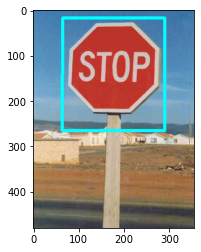

In [193]:
idx = 21
points_ref = get_vertices(img_ref)
points = convert_vertices_using_keypoint_pairs(
    points_ref, kpts[idx], kpts_ref[idx])
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

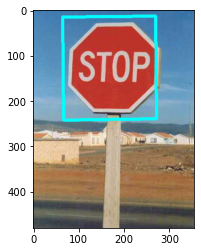

In [19]:
idx = 40
points_ref = get_vertices(img_ref)
points = convert_vertices_using_keypoint_pairs(
    points_ref, kpts[idx], kpts_ref[idx])
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

# Hough Transform

Maybe let's just use 2 quantization levels for each param in the votes. We have 4 params per vote, i.e., 16 candidate boxes.

In [147]:
voters = np.vstack([
    (kp.size, 
     kp.angle, 
     kp.pt[0], 
     kp.pt[1]) for kp in kpts
])

In [148]:
# get bins
upper = voters.max(axis=0)
lower = voters.min(axis=0)
middle = (upper + lower) / 2
dist = middle - lower
bins = np.vstack([
    lower - dist,
    middle,
    upper + dist
])

In [149]:
bins

array([[ -15.5612554 , -172.07182312,  -15.06837463,  -64.85916519],
       [  19.22947472,  181.4103241 ,  179.68635559,  150.72227859],
       [  54.02020484,  534.89247131,  374.44108582,  366.30372238]])

In [150]:
votes = np.vstack([
    np.digitize(voters[:, i], bins[:, i], right=False)
    for i in range(voters.shape[1])
]).T

In [151]:
from collections import Counter

In [152]:
votes.shape

(74, 4)

In [153]:
vote_tuples = tuple([tuple(row) for row in votes])
vote_counter = Counter(vote_tuples)

In [154]:
vote_counter.most_common()

[((1, 1, 1, 1), 15),
 ((1, 1, 2, 1), 11),
 ((1, 2, 1, 1), 9),
 ((1, 1, 1, 2), 9),
 ((1, 1, 2, 2), 8),
 ((1, 2, 1, 2), 7),
 ((1, 2, 2, 1), 6),
 ((1, 2, 2, 2), 5),
 ((2, 1, 2, 1), 2),
 ((2, 2, 1, 1), 1),
 ((2, 2, 2, 1), 1)]

In [162]:
# who casted the votes?
winner = vote_counter.most_common()[0][0]
good_voters = np.where((votes == winner).all(axis=1))[0]

In [163]:
good_voters # index into keypoints

array([ 0,  4,  6,  9, 10, 13, 14, 15, 21, 22, 23, 29, 35, 37, 38])

In [133]:
# dequantize, can probably use a class for the quantizer
vals = bins[0] + np.array(winner) * dist
vals

array([ 1.83410966,  4.66925049, 82.30899048, 42.9315567 ])

In [136]:
kpts[0].size, kpts[0].angle, kpts[0].pt

(2.735447645187378, 47.735321044921875, (82.30899047851562, 82.58668518066406))

In [182]:
kpts[0].size / kpts_ref[0].size,\
kpts[0].angle - kpts_ref[0].angle, \
np.array(kpts[0].pt) - np.array(kpts_ref[0].pt)

(1.0665906912197693, 1.343658447265625, array([65.03007126, 16.90093231]))

In [183]:
params2 = [
    kpts[0].size / kpts_ref[0].size,
kpts[0].angle - kpts_ref[0].angle,
    kpts[0].pt[0] - kpts_ref[0].pt[0],
    kpts[0].pt[1] - kpts_ref[0].pt[1]
]

In [184]:
# get params

params = np.vstack([
    (kpts[idx].size / kpts_ref[idx].size, 
     kpts[idx].angle - kpts_ref[idx].angle, 
     kpts[idx].pt[0] - kpts_ref[idx].pt[0], 
     kpts[idx].pt[1] - kpts_ref[idx].pt[1])
    for idx in good_voters
]).mean(axis=0)

In [185]:
params

array([ 1.00330494, -0.07250773, 65.01711299, 16.98736509])

In [196]:
def convert_vertices_using_params(points, params):
    """
    helper for visualization, probabaly not used in final
    vertices: from the reference image
    keypt: a single keypoint
    """
    scale, angle, _, _ = params
    kp_pt = params[2:]
    
    # scale
    points *= scale
    
    # translation
    points += kp_pt
    
    # rotation
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    points = points @ R.T
    
    return points

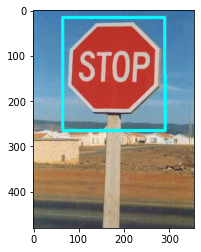

In [197]:
# which point from the reference key point to use here???
# any one from the good voter class will do???
points_ref = get_vertices(img_ref)
points = convert_vertices_using_params(points_ref, params)
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)

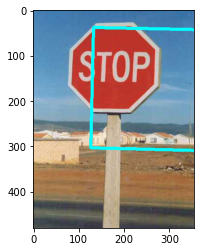

In [198]:
points = convert_vertices_using_params(points_ref, params2)
vertices = reshape_vertices_for_cv2(points)
im = draw_bounding_box(img1, vertices)
plt.imshow(im)